## Function code as of now

In [1]:
import os
import anndata
import sys
import numpy as np
wd = '/home/clarice/Documents/SingleCell_PseudoTime/'
os.chdir(wd)
sys.path.append('extras/Stabilized_ICA')

from scycle.preprocess import quality_control, prep_pooling
from scycle.tools import dimensionality_reduction, enrich_components, principal_circle

def renormalize_by_partition(adata_src, adata_ref, verbose = True):
    #-- Run QC
    params = adata_ref.uns['scycle']
    pp_params = params['preprocess']
    dr_params = params['dimRed']

    quality_control(adata_src,
                    min_counts = pp_params['min_counts'], 
                    max_counts = pp_params['max_counts'], 
                    max_mt_ratio = pp_params['max_mt_ratio'],
                    verbose = False)
    old_totals = adata_src.obs['total_counts']
    
    #---- Check if samples are the same
    if not np.all(adata_src.obs.index.values == adata_ref.obs.index.values):
        raise Exception ( 'adata_ref must contain cells in adata_src')
    
    #--- Apply filter
    if verbose: print('Normalizing by partition...')

    #---- Get partitions and re-noralize
    prt = adata_ref.obs['partition']
    gexp = adata_src.X
    
    npart = np.max(prt)+1
    new_gexp = np.empty(gexp.shape)
    for p in range(npart):
        sidx = prt == p # sample index
        totals = np.sum(gexp[sidx,:], axis = 1) # total counts per sample in group
        median = np.median(totals) # median counts for samples in group
        new_gexp[sidx,:] = gexp[sidx,:] / totals[:,None] * median
        
    #---- Re-run procedure
    adata_src.X = new_gexp
    
    if verbose: print('Re-running pooling...')
    
    prep_pooling(adata_src, 
                 filter_cells = False,
                 embed_n_comps=pp_params['embed_n_comps'],
                 min_counts = pp_params['min_counts'], 
                 max_counts = pp_params['max_counts'], 
                 max_mt_ratio = pp_params['max_mt_ratio'],
                 n_neighbors = pp_params['n_neighbors'],
                 normalize_counts = False,
                 filter_var_genes = pp_params['filter_var_genes'],
                 log_transform= pp_params['log_transform'],
                 n_top_genes = pp_params['n_top_genes'],
                 verbose = False)
    
    if verbose: print('Re-running dimensionality reduction..')
    dimensionality_reduction(adata_src,
                             method = dr_params['method'],
                             n_comps = dr_params['n_comps'],
                             seed = dr_params['seed'],
                             verbose = False)
    if 'enrich_components' in params.keys():    
        if verbose: print('Re-running component enrichment...')
        enrich_components(adata_src, verbose = False)
    
    if verbose: print('Finding the principal circle...')
    principal_circle(adata_src, n_nodes = params['principal_circle']['n_nodes'], verbose = False)
    
    adata_src.obs['total_counts'] = old_totals

## Re-normalize test

In [2]:
sces = anndata.read_loom('data/CHLA9.loom')
sces.var_names_make_unique()

#-- Hack to make this work (need to figure out why it fails with sparse matrix)
sces = anndata.AnnData(X = sces.X.toarray(), obs = sces.obs, var = sces.var)
sces.obs['total_counts'] = sces.obs['TotalUMIs']

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
import scycle as cc
sces_raw = sces.copy()

#-- Pre-process
cc.pp.prep_pooling(sces)
cc.pp.score_cell_cycle(sces)
#-- Find the trajectory
cc.tl.dimensionality_reduction(sces, method = 'ica')
cc.tl.enrich_components(sces)
cc.tl.principal_circle(sces)

Preparing embedding...
3823 samples pass the count filter
4599  samples pass the mt filter
Samples selected 3746


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Embedding for pooling...
Pooling 3746 samples...


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


-- Scoring G1 genes...
-- Scoring S-phase...
-- Scoring G2-M...


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


-- Scoring Histones...
Found histone genes: H4C3 H2AZ1 H3-3B H1-5 H1-3 H1-10 H1-2 H1-4 H2AZ2 H2AX H1-0 H2AC20 H3-3A H3C2 H2AC12 H2AJ H2BC4 H2AC16 H4C11 H3C13 H2AC14 H2BC5 H2AC15 H2AW H2AC8 H2BC6 H2AC6 H2AC21 H2AC17 H2BC15 H19 H3C3 H2BC19P H3C11 H3C12 H2BC13 H4C14 H4C8
-- Scalling signatures...
-- Dimensionality reduction using ICA...


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


-- Done
--- Selected components:
G1/S: 2
G2/M: 10
G2/M-: 5
Histones: 0
The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  3746  points and  4  dimensions
BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||4	56332.3248	4	4	4	0	0	0	39036.7785	36409.9324	0.6443	0.6683	2763.5806	14531.9656	58127.8626	232511.4503	0
0||5	46065.0557	5	5	5	0	0	0	30759.9843	27727.5915	0.7198	0.7474	3263.1418	12041.9296	60209.6481	301048.2406	0
0||6	37976.4978	6	6	6	0	0	0	25401.0849	22502.1863	0.7686	0.795	3390.7037	9184.70

/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide


0||8	30251.0925	8	8	8	0	0	0	21194.6598	18638.6389	0.8069	0.8302	3320.5095	5735.9232	45887.3854	367099.0832	0
0||9	27441.145	9	9	9	0	0	0	19710.2203	17372.8311	0.8204	0.8417	3191.8889	4539.0358	40851.322	367661.8976	0
0||10	25303.8851	10	10	10	0	0	0	18412.5311	16370.8812	0.8322	0.8508	3084.6746	3806.6795	38066.7948	380667.9482	0
0||11	23796.4596	11	11	11	0	0	0	17646.2198	15843.838	0.8392	0.8556	2900.2262	3250.0137	35750.1502	393251.6527	0
0||12	22452.6723	12	12	12	0	0	0	16891.699	15344.2687	0.8461	0.8602	2760.137	2800.8363	33610.0357	403320.4284	0
0||13	21462.362	13	13	13	0	0	0	16094.3058	14616.6176	0.8534	0.8668	2762.9266	2605.1297	33866.6859	440266.9164	0
0||14	20603.3248	14	14	14	0	0	0	15647.9058	14277.0733	0.8574	0.8699	2686.5212	2268.8977	31764.5684	444703.958	0
0||15	19798.7444	15	15	15	0	0	0	15301.6602	14142.2555	0.8606	0.8712	2508.7069	1988.3773	29825.6601	447384.9013	0
0||16	18895.385	16	16	16	0	0	0	14490.7512	13423.1186	0.868	0.8777	2504.3074	1900.3264	30405.223	486483.5683	0
0

In [4]:
#-- Re-normalize
renormalize_by_partition(sces_raw, sces)

/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Normalizing by partition...
Re-running pooling...


/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
/home/clarice/anaconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead


Re-running dimensionality reduction..
Re-running component enrichment...
Finding the principal circle...
The initial number of nodes must be at least 3. This will be fixed
Generating the initial configuration
Creating a circle in the plane induced by the 1st and 2nd PCs with 3 nodes
90% of the points have been used as initial conditions. Resetting.
Constructing tree 1 of 1 / Subset 1 of 1
Performing PCA
Using standard PCA
4 dimensions are being used
100.0 % of the original variance has been retained
The elastic matrix is being used. Edge configuration will be ignored
Computing EPG with  30  nodes on  3746  points and  4  dimensions
Nodes =  3 4 5 6 7 8 9 10 

/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
/home/clarice/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide


11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

0||30	13398.2632	30	30	30	0	0	0	10089.9623	9579.8902	0.9121	0.9166	2164.4411	1143.8598	34315.7952	1029473.8574	0


0.9798  seconds elapsed


### Before

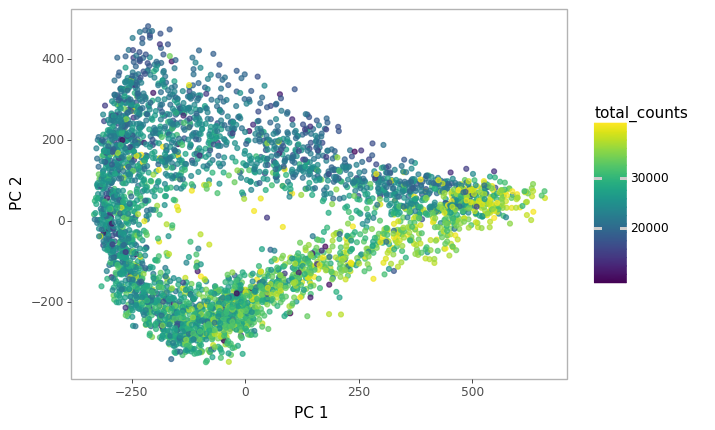

<ggplot: (8771561594373)>

In [5]:
cc.pl.scatter_projection(sces)

### After

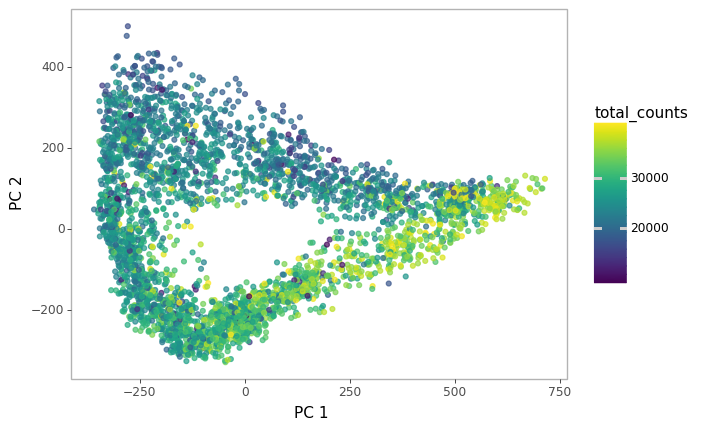

<ggplot: (8771561915509)>

In [6]:
cc.pl.scatter_projection(sces_raw)